In [1]:
# 若已加载保存的数据则不要运行！！！

import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

# 参数设置
N = 30000  # 粒子数
num_A = 24000  # A 的初始数量
num_B = N - num_A  # B 的初始数量
n_max = 10  # 最大能量计算距离
sigma = 2**(-1/6)  # Lennard-Jones归一化参数
beta = 1  # 逆温度
step = 0 # MCMC过程步数

# Lennard-Jones 势能参数
epsilon_matrix = {
    ('A', 'A'): 1,
    ('A', 'B'): 2,
    ('B', 'A'): 2,
    ('B', 'B'): 4
}


In [2]:
# 定义函数

def positions_to_particles(A_positions, B_positions, N):
    # 根据 A 和 B 的位置索引，生成 particles 数组。
    particles = np.array([''] * N)  # 先创建空数组
    particles[A_positions] = 'A'  # 在 A 位置填充 'A'
    particles[B_positions] = 'B'  # 在 B 位置填充 'B'
    return particles

# Lennard-Jones 能量函数
def lennard_jones(r, epsilon):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

# 计算总能量（包含循环边界条件）
def total_energy(particles):
    energy = 0.0
    for i in range(N):
        for j in range(1, n_max + 1):
            neighbor = (i + j) % N
            r = np.abs(j)
            epsilon = epsilon_matrix[(particles[i], particles[neighbor])]
            energy += lennard_jones(r, epsilon)
    return energy

def part_energy(particles, i):
    energy = 0.0
    for j in range(-n_max, n_max + 1):
        if j == 0:
            continue
        neighbor = (i + j) % N
        r = np.abs(j)
        epsilon = epsilon_matrix[(particles[i], particles[neighbor])]
        energy += lennard_jones(r, epsilon)
    return energy

# Gibbs 采样步骤（保持 A 和 B 数量不变）
def gibbs_step(A_positions, B_positions, energy):
    """
    Gibbs 采样：对随机 A 粒子选择最可能的 B 粒子进行交换
    """
    i = np.random.choice(len(A_positions))
    energy_changes = []
    swap_candidates = []
    particles = positions_to_particles(A_positions, B_positions, N)
    
    for j in range(len(B_positions)):  # 遍历所有 B 粒子
        # new_A_positions = A_positions.copy()
        # new_B_positions = B_positions.copy()
        
        # 交换 A 和 B
        # new_A_positions[i], new_B_positions[j] = new_B_positions[j], new_A_positions[i]
        
        # 计算新状态的总能量
        # new_particles = positions_to_particles(new_A_positions, new_B_positions, N)
        # new_energy = total_energy(new_particles)
        # delta_energy = new_energy - energy

        old_part_energy = part_energy(particles, A_positions[i]) + part_energy(particles, B_positions[j])
        particles[A_positions[i]], particles[B_positions[j]] = particles[B_positions[j]], particles[A_positions[i]]
        new_part_energy = part_energy(particles, A_positions[i]) + part_energy(particles, B_positions[j])
        particles[A_positions[i]], particles[B_positions[j]] = particles[B_positions[j]], particles[A_positions[i]]

        delta_energy = new_part_energy - old_part_energy
        energy_changes.append(delta_energy)
        swap_candidates.append(j)

    # Gibbs 采样概率计算
    exp_probs = np.exp(-beta * np.array(energy_changes))
    probs = exp_probs / np.sum(exp_probs)  # 归一化

    # 按概率选取一个 B 粒子进行交换
    chosen_B = np.random.choice(swap_candidates, p=probs)

    # 更新 A 和 B 的位置
    A_positions[i], B_positions[chosen_B] = B_positions[chosen_B], A_positions[i]
    energy = total_energy(positions_to_particles(A_positions, B_positions, N))  # 更新系统能量

    return A_positions, B_positions, energy


In [ ]:
# 若已加载保存的数据则不要运行！！！

# 初始化粒子类别，保持 A 和 B 的数量不变
all_positions = np.arange(N)
np.random.shuffle(all_positions)
A_positions = np.sort(all_positions[:num_A])  # 取前 50 个作为 A
B_positions = np.sort(all_positions[num_A:])  # 剩下的作为 B

# 初始化
energy = total_energy(positions_to_particles(A_positions, B_positions, N))
print(energy)
samples = []
energy_history = []

In [ ]:
# 运行 Gibbs 采样 MCMC

num_steps = 10000  # 采样步数
record_steps = 30  # 记录一次样本的步长

for i in range(num_steps):
    step += 1
    A_positions, B_positions, energy = gibbs_step(A_positions, B_positions, energy)
    energy_history.append(energy)
    if step % record_steps == 0:
        samples.append(positions_to_particles(A_positions, B_positions, N).copy())
        print(f"Step {step}, Energy: {energy}")


In [ ]:
# 绘制能量变化曲线
plt.plot(energy_history)
plt.xlabel("Gibbs Sampling Step")
plt.ylabel("Total Energy")
plt.title("Energy Evolution using Gibbs Sampling")
plt.show()

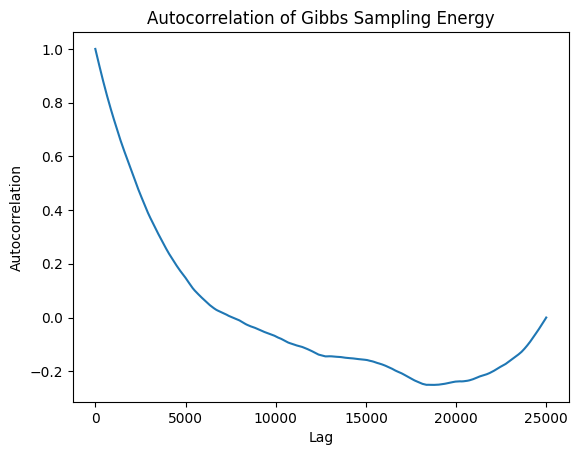

In [3]:
from statsmodels.tsa.stattools import acf
autocorr = acf(energy_history[:], nlags=25000)
plt.plot(autocorr)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Gibbs Sampling Energy")
plt.show()

# 当自相关值接近 0 时，说明采样点已经独立，达到平衡态。

a step of Gibbs Sampling:
- Choose a random $A$ particle, and calculate energy changes $E_i$ of different $B_i$ particles.
- Exchange $A$ and $B_i$ with probability $\frac{e^{-\beta E_i}}{\sum_i e^{-\beta E_i}}$

In [13]:
# 存储变量
import pickle

def save_variables(filename, variables):
    """
    保存变量到文件
    :param filename: 保存的文件名
    :param variables: 需要保存的变量字典
    """
    with open(filename, 'wb') as f:
        pickle.dump(variables, f)

# 假设以下变量是我们需要存储的
variables_to_save = {
    'N': N,
    'num_A': num_A,
    'num_B': num_B,
    'n_max': n_max,
    'sigma': sigma,
    'beta': beta,
    'step': step,
    'epsilon_matrix': epsilon_matrix,
    'A_positions': A_positions,
    'B_positions': B_positions,
    'energy': energy,
    'energy_history': energy_history,
    'samples': samples,
}

# 存储变量
filename = f'data_N{N}_A{num_A}_B{num_B}_step{step}.pkl'
save_variables(filename, variables_to_save)

In [2]:
# 加载变量
import numpy as np
import matplotlib.pyplot as plt
import pickle

def load_variables(filename):
    """
    从文件加载变量
    :param filename: 变量文件名
    :return: 变量字典
    """
    with open(filename, 'rb') as f:
        variables = pickle.load(f)
    return variables
np.set_printoptions(threshold=np.inf)

N = 30000
num_A = 24000
num_B = N - num_A
step = 25000
filename = f'data_N{N}_A{num_A}_B{num_B}_step{step}.pkl'
globals().update(load_variables(filename))